# 第4週：對以東森新聞的國際新聞進行情緒分析

本週課程為「情緒分析1」，目的為了解lexicon-base 情緒分析。情緒分析步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「中文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、資料前處理、lexicon-base 情緒分析

## 大綱
+ 1. 套件說明
+ 2. 資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 文章斷詞
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒詞彙頻率折線圖圖
    + 3.4 正負向情緒詞彙比例折線圖圖
    + 3.5 正負向情緒分數折線圖圖
    + 3.6 文章為單位的情緒分析
    + 3.7 情緒代表字
    + 3.8 文字雲

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- matplotlib: 繪圖工具。
- wordcloud: 繪製文字雲工具。
- jieba: 中文斷詞工具。

## 本機使用套間
請先於環境中使用 pip install

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

## colab 使用套件

In [143]:
# !pip install pandas
# !pip install matplotlib
# !pip install wordcloud
# !pip install jieba

In [2]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 2. 資料前處理
如 week3 所示  
使用「吃到飽」作為關鍵字，從工作流程系統中將 ptt 資料下載下來

### 2.1 基本資料介紹
資料來源：
+ 東森新聞裡有關以巴衝突的新聞
+ 關鍵字：「以巴衝突, 以色列, 巴勒斯坦」
+ 時間： 2023-10-07 ~ 2024-03-09
+ 資料筆數：共 605 篇新聞

In [3]:
df = pd.read_csv("../week3/raw_data/Israel–Hamas_war.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,國際,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,EBC
1,2,槍手滲透城鎮！以色列遭哈瑪斯火箭猛襲 至少22死、數百傷｜東森新聞,https://news.ebc.net.tw/news/article/385785,2023-10-07,國際,伊斯蘭主義運動組織「哈瑪斯」今天對以色列發動近年規模最大突襲，除有槍手滲透到以色列城鎮，還在...,EBC
2,3,哈瑪斯突襲以色列至少22死數百傷 外交部回應了｜東森新聞,https://news.ebc.net.tw/news/article/385796,2023-10-07,國際,伊斯蘭主義運動組織「哈瑪斯」（Hamas）對以色列發動突襲，外交部今天表示，經駐以色列代表處...,EBC
3,4,以色列爆戰爭！哈瑪斯5千火箭狂轟 17人台灣旅行團受困當地｜東森新聞,https://news.ebc.net.tw/news/article/385802,2023-10-07,國際,伊斯蘭主義運動組織「哈瑪斯」今（7）日對以色列展開攻擊，發射5000枚火箭，而以色列總理也證...,EBC
4,5,以巴衝突增至232死 以國22地點爆激戰｜東森新聞,https://news.ebc.net.tw/news/article/385820,2023-10-08,國際,巴勒斯坦伊斯蘭主義團體「哈瑪斯」對以色列發動大規模攻擊，以方隨後展開反擊。根據加薩走廊（Ga...,EBC


### 2.2資料清理

In [4]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id','artCatagory', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,artTitle,artUrl,artDate,artContent,sentence
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...
1,槍手滲透城鎮！以色列遭哈瑪斯火箭猛襲 至少22死、數百傷｜東森新聞,https://news.ebc.net.tw/news/article/385785,2023-10-07,伊斯蘭主義運動組織「哈瑪斯」今天對以色列發動近年規模最大突襲，除有槍手滲透到以色列城鎮，還在...,伊斯蘭主義運動組織「哈瑪斯」今天對以色列發動近年規模最大突襲，除有槍手滲透到以色列城鎮，還在...
2,哈瑪斯突襲以色列至少22死數百傷 外交部回應了｜東森新聞,https://news.ebc.net.tw/news/article/385796,2023-10-07,伊斯蘭主義運動組織「哈瑪斯」（Hamas）對以色列發動突襲，外交部今天表示，經駐以色列代表處...,伊斯蘭主義運動組織「哈瑪斯」（Hamas）對以色列發動突襲，外交部今天表示，經駐以色列代表處...
3,以色列爆戰爭！哈瑪斯5千火箭狂轟 17人台灣旅行團受困當地｜東森新聞,https://news.ebc.net.tw/news/article/385802,2023-10-07,伊斯蘭主義運動組織「哈瑪斯」今（7）日對以色列展開攻擊，發射5000枚火箭，而以色列總理也證...,伊斯蘭主義運動組織「哈瑪斯」今（7）日對以色列展開攻擊，發射5000枚火箭，而以色列總理也證...
4,以巴衝突增至232死 以國22地點爆激戰｜東森新聞,https://news.ebc.net.tw/news/article/385820,2023-10-08,巴勒斯坦伊斯蘭主義團體「哈瑪斯」對以色列發動大規模攻擊，以方隨後展開反擊。根據加薩走廊（Ga...,巴勒斯坦伊斯蘭主義團體「哈瑪斯」對以色列發動大規模攻擊，以方隨後展開反擊。根據加薩走廊（Ga...
...,...,...,...,...,...
600,加薩戰爭迄今近5個月 以色列地方選舉成民意風向球｜東森新聞,https://news.ebc.net.tw/news/article/407418,2024-02-28,以色列昨天舉行兩度延宕的市議員選舉，隨著以哈戰爭爆發近5個月，這場選舉讓外界得以從中一窺以色...,以色列昨天舉行兩度延宕的市議員選舉，隨著以哈戰爭爆發近5個月，這場選舉讓外界得以從中一窺以色...
601,密州初選拜登川普雙過關 選民動向備受兩黨關注｜東森新聞,https://news.ebc.net.tw/news/article/407510,2024-02-28,美國密西根州今天舉行兩黨總統提名初選，民主黨籍的現任總統拜登和共和黨參選人川普雙雙取勝，然而...,美國密西根州今天舉行兩黨總統提名初選，民主黨籍的現任總統拜登和共和黨參選人川普雙雙取勝，然而...
602,拜登稱停火在即遭以哈打臉 卡達態度洩玄機｜東森新聞,https://news.ebc.net.tw/news/article/407559,2024-02-28,美國總統拜登26號才說以色列跟哈瑪斯有望在3月4號停火，慘遭雙方打臉否認。另一方面，負責斡旋...,美國總統拜登26號才說以色列跟哈瑪斯有望在3月4號停火，慘遭雙方打臉否認。另一方面，負責斡旋...
603,加薩搶糧混戰逾百死 拜登：美軍將空投物資｜東森新聞,https://news.ebc.net.tw/news/article/407989,2024-03-02,加薩市昨天發生以色列軍人被控朝搶糧的巴勒斯坦人開槍造成逾百死事件，當地人道災難持續惡化再度引...,加薩市昨天發生以色列軍人被控朝搶糧的巴勒斯坦人開槍造成逾百死事件，當地人道災難持續惡化再度引...


斷句

In [5]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

,artTitle,artUrl,artDate,artContent,sentence
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社記者報導
1,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,以色列軍隊今天已對加薩走廊發動至少2次空襲
2,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,在此之前
3,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,哈瑪斯集團從加薩走廊向以色列發射大量火箭
4,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,以色列總理尼坦雅胡表示
...,...,...,...,...,...
24349,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,」拜登5號向記者表示
24350,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,美國卡達還有埃及都在努力促成雙方協議
24351,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,希望能在3月10號齋戒月開始前達成停火
24352,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,讓更多救援物資進到加薩


In [6]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')
jieba.add_word('以巴衝突')
jieba.add_word('以色列')
jieba.add_word('巴勒斯坦')

Building prefix dict from c:\Users\USER\Desktop\final_scribble\SMA\week4\dict\dict.txt ...
Dumping model to file cache C:\Users\USER\AppData\Local\Temp\jieba.u9b8f18b440de33e21c39365a46bbd61d.cache
Loading model cost 0.512 seconds.
Prefix dict has been built successfully.


In [7]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,artTitle,artUrl,artDate,artContent,sentence
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社記者報導
1,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,以色列軍隊今天已對加薩走廊發動至少2次空襲
2,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,在此之前
3,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,哈瑪斯集團從加薩走廊向以色列發射大量火箭
4,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,以色列總理尼坦雅胡表示
...,...,...,...,...,...
24348,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,我們現在不知道但這幾天就會知道結果
24349,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,拜登5號向記者表示
24350,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,美國卡達還有埃及都在努力促成雙方協議
24351,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,希望能在3月10號齋戒月開始前達成停火


### 2.3 文章斷詞

In [8]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

,artTitle,artUrl,artDate,artContent,word
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,記者
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,報導
1,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,以色列
1,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,軍隊
...,...,...,...,...,...
24352,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,更多
24352,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,救援
24352,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,物資
24352,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,進到


移除停用字

In [9]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
# stopwords_manual = ["吃到飽", "餐廳", "名稱", "消費", "時間", "地址", "營業", "吃起來", "一點", "電話", "每人", "平均", "價位", "吃到", "看到"]
stopwords_manual = ["以色列", "巴勒斯坦", "以巴衝突", "現在", "目前", "地址", "營業", "看到", "指出", "10"]
stopwords.extend(stopwords_manual)

In [10]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artTitle,artUrl,artDate,artContent,word
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,記者
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,報導
1,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,軍隊
1,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,今天
...,...,...,...,...,...
24352,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,更多
24352,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,救援
24352,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,物資
24352,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,https://news.ebc.net.tw/news/article/408692,2024-03-06,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,進到


## 3. Lexicon-based 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

In [11]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [12]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

```merge function 介紹```
https://www.delftstack.com/zh-tw/howto/python-pandas/merge-dataframes-on-index-in-pandas/

In [13]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社,NaN
1,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,記者,NaN
2,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,報導,NaN
3,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,軍隊,NaN
4,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,今天,NaN
...,...,...,...,...,...,...
108187,https://news.ebc.net.tw/news/article/408692,2024-03-06,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,更多,NaN
108188,https://news.ebc.net.tw/news/article/408692,2024-03-06,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,救援,NaN
108189,https://news.ebc.net.tw/news/article/408692,2024-03-06,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,物資,NaN
108190,https://news.ebc.net.tw/news/article/408692,2024-03-06,以巴衝突滿五個月！ 美軍持續空投加薩物資｜東森新聞,堆高機把物資放到運輸機上，箱子旁印著約旦國旗，還有手寫字條，寫著與你同在為你祈禱。約旦空軍5...,進到,NaN


### 3.3 正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

```情緒分析指標```
在情緒分析中，我們會以不同的指標來看情緒的好壞，其中常見的包含：
1. **情感詞彙頻率**： 使用情感詞彙列表，其中包含正向和負向情感的詞彙。將文本中的詞與該列表進行匹配，計算正向和負向詞彙的出現次數，從而判斷整體情感傾向。
2. **情感詞彙比例**：不同於單純的計算頻率，比例是某種情緒（例如：正向）佔所有情緒詞中的幾分之幾。這種方法可以避免某一天文章數特別多（詞頻也會隨之變多）而影響情緒的判斷。
2. **情感詞彙分數**： 給每個情感詞彙分配一個權重或分數，然後計算文本中所有情感詞的總分。這種方法允許區分不同情感詞的影響力，進一步細化情感分析的結果。

我們先以最基本的詞頻來計算

```groupby function 介紹```https://zhuanlan.zhihu.com/p/101284491

In [14]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
3,2023-10-07,negative,42
4,2023-10-07,positive,9
9,2023-10-08,negative,302
10,2023-10-08,positive,82
15,2023-10-09,negative,627
...,...,...,...
494,2024-02-28,positive,23
499,2024-03-02,negative,6
500,2024-03-02,positive,3
504,2024-03-06,negative,1


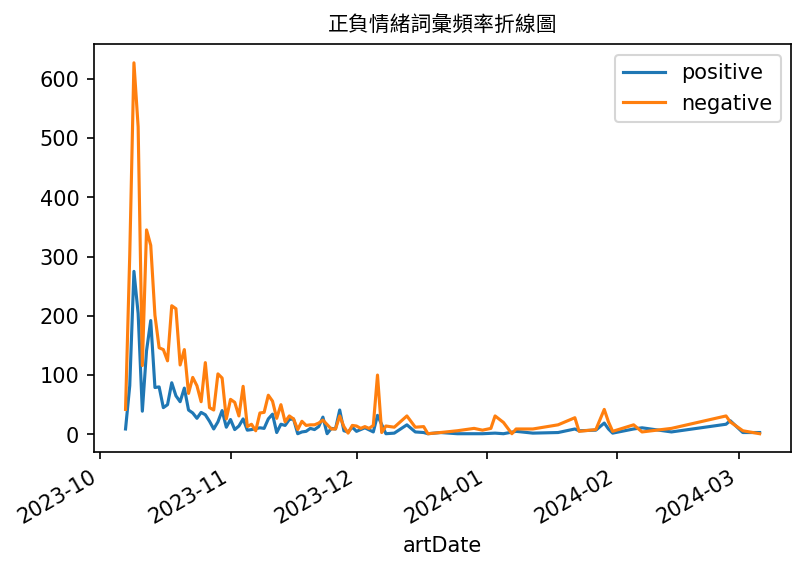

In [15]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

```Moving average```
- rolling average（滾動平均）是一種將時間序列數據平滑化的技術，有助於去除數據中的噪聲，使趨勢更加明顯，同時仍然保留一定的時間特徵。
- 在情緒分析中，特別是當你有一系列時間序列的情緒數據時，使用滾動平均有助於平滑數據，使情緒趨勢更加清晰。
    1. **去除瞬間噪聲**： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
    2. **強調長期趨勢**： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。


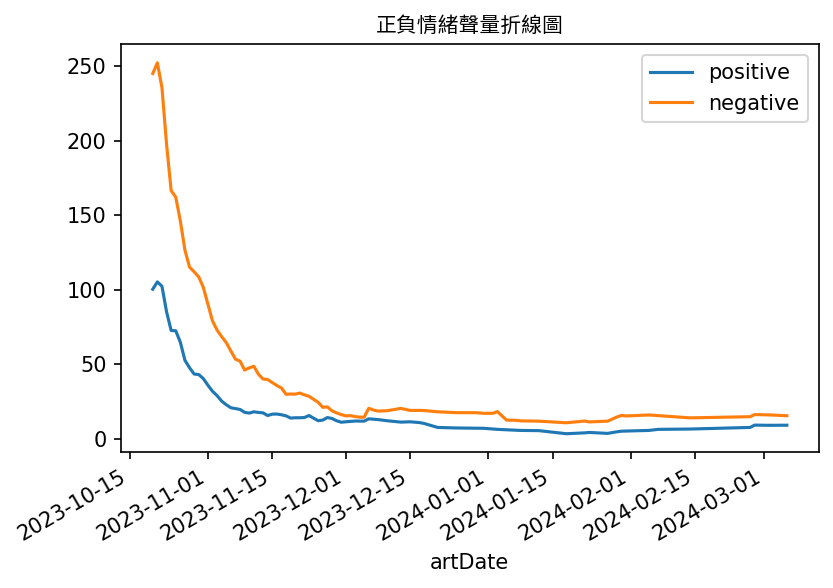

In [16]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

```詞頻缺點```

如果某一天有什麼事件發生而導致正負向詞頻數隨之飆高，在趨勢圖看來可能會認為該區間的正負向情緒較為顯著，但也有可能是因為總體情緒詞彙本來就比較多而導致的。

以比例的方式來看，我們可以觀察到某個情緒詞在總體情緒詞彙中所佔的比例，就算某一天文章數相較多，也不會影響到比例的呈現。

### 3.4 正負向情緒詞彙比例折線圖圖

```lambda```函式是一種匿名函式，包含以下幾點特性：

+ 不需要定義函式名稱
+ 只能有一行運算式
+ 執行完後會自動回傳結果，不需要return   

因此```lambda```適合在該函式只有單行運算式且不會被重複呼叫時使用

參考網址：   
[Python Lambda](https://www.w3schools.com/python/python_lambda.asp)   
[Lambda — Python 重要語法技巧](https://medium.com/johnliu-的軟體工程思維/lambda-python-重要語法技巧-27c467ddfa16)

In [17]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
3,2023-10-07,negative,42,0.823529
4,2023-10-07,positive,9,0.176471
9,2023-10-08,negative,302,0.786458
10,2023-10-08,positive,82,0.213542
15,2023-10-09,negative,627,0.695122
...,...,...,...,...
494,2024-02-28,positive,23,0.522727
499,2024-03-02,negative,6,0.666667
500,2024-03-02,positive,3,0.333333
504,2024-03-06,negative,1,0.250000


In [18]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

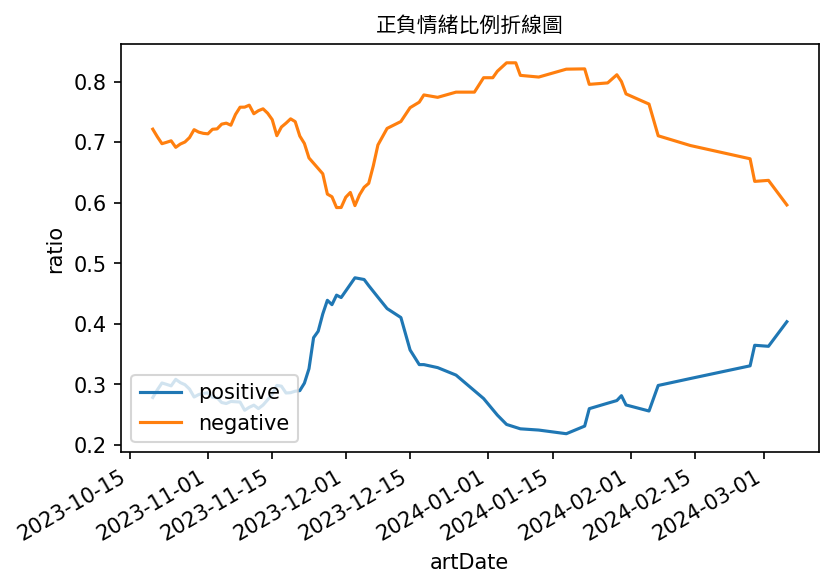

In [19]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 3.5 正負向情緒分數折線圖

In [20]:
sentiment_count

,artDate,sentiments,size,ratio
3,2023-10-07,negative,42,0.823529
4,2023-10-07,positive,9,0.176471
9,2023-10-08,negative,302,0.786458
10,2023-10-08,positive,82,0.213542
15,2023-10-09,negative,627,0.695122
...,...,...,...,...
494,2024-02-28,positive,23,0.522727
499,2024-03-02,negative,6,0.666667
500,2024-03-02,positive,3,0.333333
504,2024-03-06,negative,1,0.250000


In [21]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2023-10-07,42.0,9.0
1,2023-10-08,302.0,82.0
2,2023-10-09,627.0,275.0
3,2023-10-10,519.0,204.0
4,2023-10-11,116.0,39.0


In [22]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2023-10-07,42.0,9.0,-33.0
1,2023-10-08,302.0,82.0,-220.0
2,2023-10-09,627.0,275.0,-352.0
3,2023-10-10,519.0,204.0,-315.0
4,2023-10-11,116.0,39.0,-77.0


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

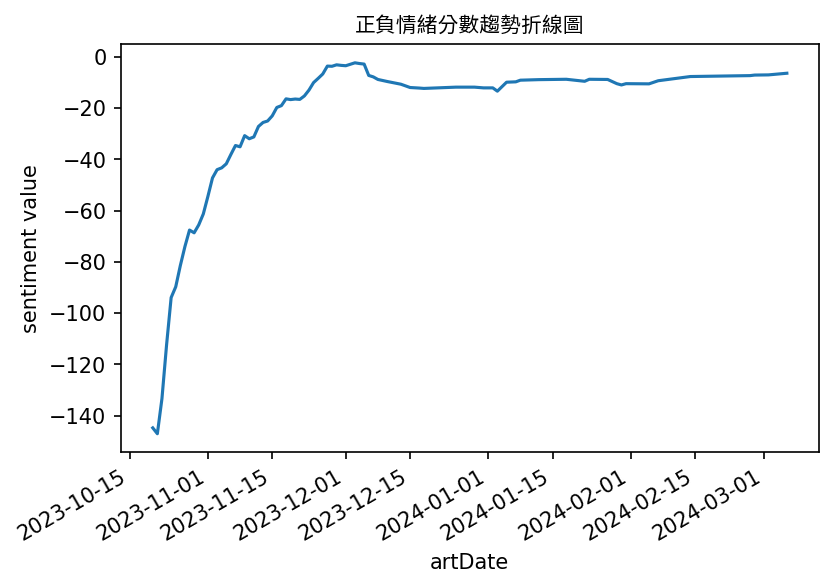

In [23]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.6 文章為單位的情緒分析

In [24]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

,artUrl,sentiments,size
0,https://news.ebc.net.tw/news/article/385783,affect,16
1,https://news.ebc.net.tw/news/article/385783,anger,4
2,https://news.ebc.net.tw/news/article/385783,anx,2
3,https://news.ebc.net.tw/news/article/385783,negative,14
4,https://news.ebc.net.tw/news/article/385783,positive,2
...,...,...,...
3053,https://news.ebc.net.tw/news/article/407989,sad,1
3054,https://news.ebc.net.tw/news/article/408692,affect,4
3055,https://news.ebc.net.tw/news/article/408692,anger,1
3056,https://news.ebc.net.tw/news/article/408692,negative,1


In [25]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://news.ebc.net.tw/news/article/385783,16.0,4.0,2.0,14.0,2.0,6.0
1,https://news.ebc.net.tw/news/article/385785,12.0,5.0,2.0,11.0,1.0,3.0
2,https://news.ebc.net.tw/news/article/385796,15.0,5.0,3.0,11.0,2.0,2.0
3,https://news.ebc.net.tw/news/article/385802,11.0,2.0,2.0,6.0,4.0,1.0
4,https://news.ebc.net.tw/news/article/385820,12.0,6.0,2.0,12.0,0.0,1.0


In [26]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://news.ebc.net.tw/news/article/385783,16.0,4.0,2.0,14.0,2.0,6.0,-12.0
1,https://news.ebc.net.tw/news/article/385785,12.0,5.0,2.0,11.0,1.0,3.0,-10.0
2,https://news.ebc.net.tw/news/article/385796,15.0,5.0,3.0,11.0,2.0,2.0,-9.0
3,https://news.ebc.net.tw/news/article/385802,11.0,2.0,2.0,6.0,4.0,1.0,-2.0
4,https://news.ebc.net.tw/news/article/385820,12.0,6.0,2.0,12.0,0.0,1.0,-12.0


In [27]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://news.ebc.net.tw/news/article/385783,16.0,4.0,2.0,14.0,2.0,6.0,-12.0,負向
1,https://news.ebc.net.tw/news/article/385785,12.0,5.0,2.0,11.0,1.0,3.0,-10.0,負向
2,https://news.ebc.net.tw/news/article/385796,15.0,5.0,3.0,11.0,2.0,2.0,-9.0,負向
3,https://news.ebc.net.tw/news/article/385802,11.0,2.0,2.0,6.0,4.0,1.0,-2.0,負向
4,https://news.ebc.net.tw/news/article/385820,12.0,6.0,2.0,12.0,0.0,1.0,-12.0,負向
...,...,...,...,...,...,...,...,...,...
592,https://news.ebc.net.tw/news/article/407418,8.0,4.0,0.0,6.0,2.0,0.0,-4.0,負向
593,https://news.ebc.net.tw/news/article/407510,21.0,3.0,4.0,9.0,12.0,0.0,3.0,正向
594,https://news.ebc.net.tw/news/article/407559,15.0,5.0,0.0,6.0,9.0,1.0,3.0,正向
595,https://news.ebc.net.tw/news/article/407989,9.0,1.0,1.0,6.0,3.0,1.0,-3.0,負向


In [28]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource,sentiment_class
0,1,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,國際,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,EBC,負向
1,2,槍手滲透城鎮！以色列遭哈瑪斯火箭猛襲 至少22死、數百傷｜東森新聞,https://news.ebc.net.tw/news/article/385785,2023-10-07,國際,伊斯蘭主義運動組織「哈瑪斯」今天對以色列發動近年規模最大突襲，除有槍手滲透到以色列城鎮，還在...,EBC,負向
2,3,哈瑪斯突襲以色列至少22死數百傷 外交部回應了｜東森新聞,https://news.ebc.net.tw/news/article/385796,2023-10-07,國際,伊斯蘭主義運動組織「哈瑪斯」（Hamas）對以色列發動突襲，外交部今天表示，經駐以色列代表處...,EBC,負向
3,4,以色列爆戰爭！哈瑪斯5千火箭狂轟 17人台灣旅行團受困當地｜東森新聞,https://news.ebc.net.tw/news/article/385802,2023-10-07,國際,伊斯蘭主義運動組織「哈瑪斯」今（7）日對以色列展開攻擊，發射5000枚火箭，而以色列總理也證...,EBC,負向
4,5,以巴衝突增至232死 以國22地點爆激戰｜東森新聞,https://news.ebc.net.tw/news/article/385820,2023-10-08,國際,巴勒斯坦伊斯蘭主義團體「哈瑪斯」對以色列發動大規模攻擊，以方隨後展開反擊。根據加薩走廊（Ga...,EBC,負向
...,...,...,...,...,...,...,...,...
600,601,加薩戰爭迄今近5個月 以色列地方選舉成民意風向球｜東森新聞,https://news.ebc.net.tw/news/article/407418,2024-02-28,國際,以色列昨天舉行兩度延宕的市議員選舉，隨著以哈戰爭爆發近5個月，這場選舉讓外界得以從中一窺以色...,EBC,負向
601,602,密州初選拜登川普雙過關 選民動向備受兩黨關注｜東森新聞,https://news.ebc.net.tw/news/article/407510,2024-02-28,國際,美國密西根州今天舉行兩黨總統提名初選，民主黨籍的現任總統拜登和共和黨參選人川普雙雙取勝，然而...,EBC,正向
602,603,拜登稱停火在即遭以哈打臉 卡達態度洩玄機｜東森新聞,https://news.ebc.net.tw/news/article/407559,2024-02-28,國際,美國總統拜登26號才說以色列跟哈瑪斯有望在3月4號停火，慘遭雙方打臉否認。另一方面，負責斡旋...,EBC,正向
603,604,加薩搶糧混戰逾百死 拜登：美軍將空投物資｜東森新聞,https://news.ebc.net.tw/news/article/407989,2024-03-02,國際,加薩市昨天發生以色列軍人被控朝搶糧的巴勒斯坦人開槍造成逾百死事件，當地人道災難持續惡化再度引...,EBC,負向


In [29]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2023-10-07,負向,4
1,2023-10-08,正向,1
2,2023-10-08,負向,18
3,2023-10-09,正向,7
4,2023-10-09,負向,50
...,...,...,...
126,2024-02-27,負向,1
127,2024-02-28,正向,2
128,2024-02-28,負向,1
129,2024-03-02,負向,1


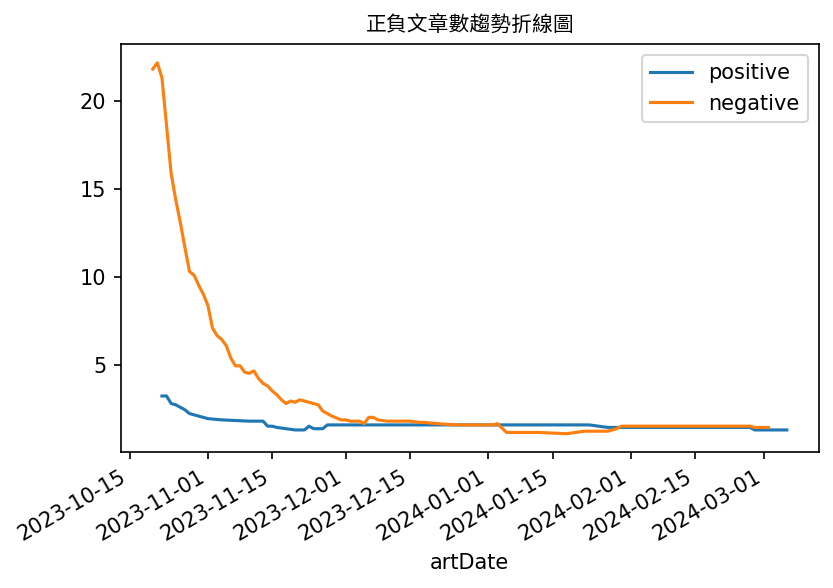

In [30]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

### 3.7 情緒代表字

In [31]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
848,攻擊,negative,642
846,攻擊,affect,642
847,攻擊,anger,642
705,戰爭,negative,383
703,戰爭,affect,383
...,...,...,...
314,哭訴,affect,1
315,哭訴,negative,1
316,哭訴,sad,1
930,欣賞,affect,1


In [32]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
841,支持,positive,266
435,安全,positive,204
485,希望,positive,148
296,和平,positive,78
106,保護,positive,75
1510,重要,positive,71
224,協助,positive,64
689,成功,positive,56
283,同意,positive,45
991,決定,positive,44


In [33]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
848,攻擊,negative,642
705,戰爭,negative,383
1383,衝突,negative,281
954,死亡,negative,228
585,恐怖,negative,185
1433,警告,negative,117
1110,爆發,negative,117
252,受傷,negative,114
708,戰鬥,negative,110
702,戰火,negative,109


C:\Users\USER\AppData\Local\Temp\ipykernel_24440\391454114.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\USER\AppData\Local\Temp\ipykernel_24440\391454114.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

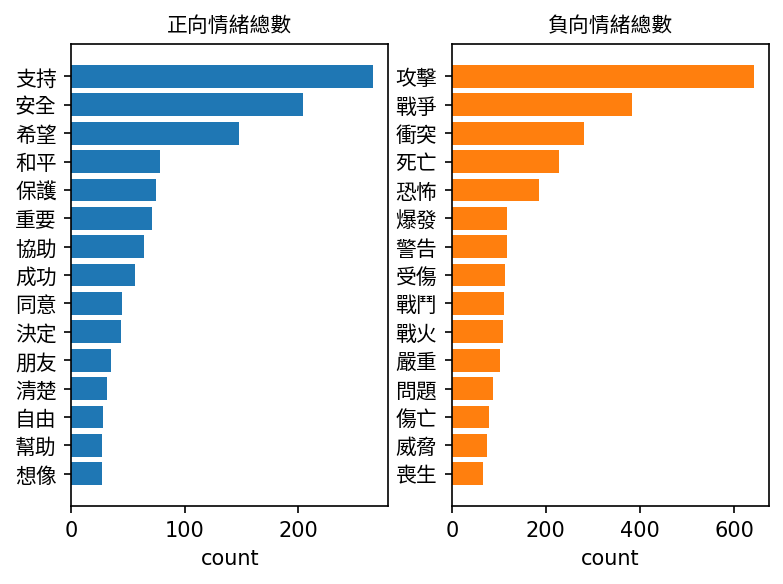

In [34]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

#### 檢查情緒詞是否符合本文本

In [116]:
filtered_df = sent_df[sent_df['sentence'].str.contains('警告', na=False)]
filtered_df.head()

,artTitle,artUrl,artDate,artContent,sentence,sentiment_class
599,哈馬斯「突襲以色列」原因曝光 5大關鍵QA一次看｜東森新聞,https://news.ebc.net.tw/news/article/385901,2023-10-08,巴勒斯坦激進組織「哈馬斯」（Hamas）在沒有任何警告的情況下，7日對以色列展開大規模突襲，...,巴勒斯坦激進組織哈馬斯Hamas在沒有任何警告的情況下,負向
1915,以巴衝突／戰火續升溫！以色列陸生：2室友被徵兵走了｜東森新聞,https://news.ebc.net.tw/news/article/385999,2023-10-09,巴勒斯坦激進組織「哈馬斯」（Hamas）7日對以色列展開大規模突襲，以色列也正式對哈瑪斯宣戰...,因此這次波及耶路撒冷地區是一個重要的警告,負向
2716,以巴衝突／哈瑪斯突襲釀千人喪命 激戰過程、各方反應一次看｜東森新聞,https://news.ebc.net.tw/news/article/386029,2023-10-09,巴勒斯坦伊斯蘭主義運動組織「哈瑪斯」（Hamas）昨天從加薩地區（Gaza）突襲以色列，以巴...,他也警告以色列必須為危害區域國家的安全負起責任,負向
3128,以巴衝突／全力支援以色列！美航母打擊群出動 威嚇中東激進分子｜東森新聞,https://news.ebc.net.tw/news/article/386056,2023-10-09,以巴烽火再起，美國國防部調派核動力航空母艦福特號打擊群前往中東地區。拜登政府強調，軍事部署只...,附近區域的警告訊息,負向
3857,以巴衝突／展開反擊！納坦雅胡警告：空襲加薩只是開端｜東森新聞,https://news.ebc.net.tw/news/article/386104,2023-10-10,以色列總理「納坦雅胡」開口警告，這一切都只是關端。以色列總理納坦雅胡：「我們現在開始（攻擊了...,以色列總理納坦雅胡開口警告,負向


In [56]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

巴勒斯坦激進組織哈馬斯Hamas在沒有任何警告的情況下
因此這次波及耶路撒冷地區是一個重要的警告
他也警告以色列必須為危害區域國家的安全負起責任
附近區域的警告訊息
以色列總理納坦雅胡開口警告
總理納坦雅胡除了警告哈瑪斯現在的攻擊只開端
表示以色列若不事先警告就空襲民宅
總理納坦雅胡發出警告
波蘭總統杜達也警告
警告目標建築裡的人撤離
攻擊前都會警告
哈瑪斯10號向以色列南部地區發出警告
他們還公開警告以色列南部阿什克隆地區的民眾
並警告居民自己離開
加薩民眾以色列在沒有任何警告的情況下
以色列早在10日就警告過埃及
以色列其實早在遇襲前3天就有接獲埃及的警告
不過埃及確實有提出警告
關鍵在於警告到什麼程度
開羅已曾多次警告特拉維夫
加薩走廊正在策劃某件大事我們已經警告過他們
但他們低估了此類警告
以色列在致命入侵前曾經接獲具體警告的相關說法及報導
文章來源埃及3天前就警告以色列
甚至經由黎巴嫩政府警告真主黨不要介入以巴衝突
而是為了要警告其他勢力不要蠢蠢欲動
紅十字國際委員會警告
發文警告馬斯克
警告加薩居民即刻往南部逃離
傳單還警告當地居民
也出聲警告美國不要干預
就是在向周邊國家發出警告
聯合國發出警告
但同時也警告
二號人物卡西姆更是出面警告
空投傳單警告
聯合國發出警告
讓聯合國趕緊發出警告
聯合國警告
甚至還先警告駐紮在附近的以色列軍隊
甚至傳出美國其實在哈瑪斯突襲的9天前就曾對以色列發出警告
多個情報警告
另一份在10月5號是來自中央情報局的警告
讓聯合國趕緊發出警告
並警告其他國家不要讓衝突升級
以色列13號警告
世界衛生組織也警告
以色列也在13日警告加薩走廊北部的居民
單方面發出警告
以色列繼續警告加薩平民趕緊撤離
也向以色列發出警告
不過國安顧問蘇利文警告
美國官員的警告剷除摧毀哈瑪斯的結果
更有專家警告以色列可能正走進哈瑪斯設下的陷阱
當時以色列軍隊警告平民趕快離開的同時
專家更警告
以色列官員更警告
同時也向周邊國家發出警告
警告伊朗和真主黨不要加入衝突
警告全球恐怕將迎來數10年來最危險的時刻
金融界依然發出警告
發出強烈的警告
美國出手警告伊朗
國民黨籍台北市議員徐弘庭就警告
警告以色列的時間已經不多
雖然以色列警告
伊朗外長日前公開警告
伊朗最高領袖哈米尼公開提告警告
現在已經發佈全球警告
警告居民向南撤離
但英國前海軍司令韋斯特警告

#### 重新計算情緒

In [105]:
# 設定要移除的字詞列表
words_to_remove = ['問題','支持','表示','造成','衝突','恐怖','戰火','攻擊','報導','摧毀','緊張']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社,NaN
1,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,記者,NaN
2,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,報導,NaN
3,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,軍隊,NaN
4,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,今天,NaN


C:\Users\USER\AppData\Local\Temp\ipykernel_24440\1465679712.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\USER\AppData\Local\Temp\ipykernel_24440\1465679712.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

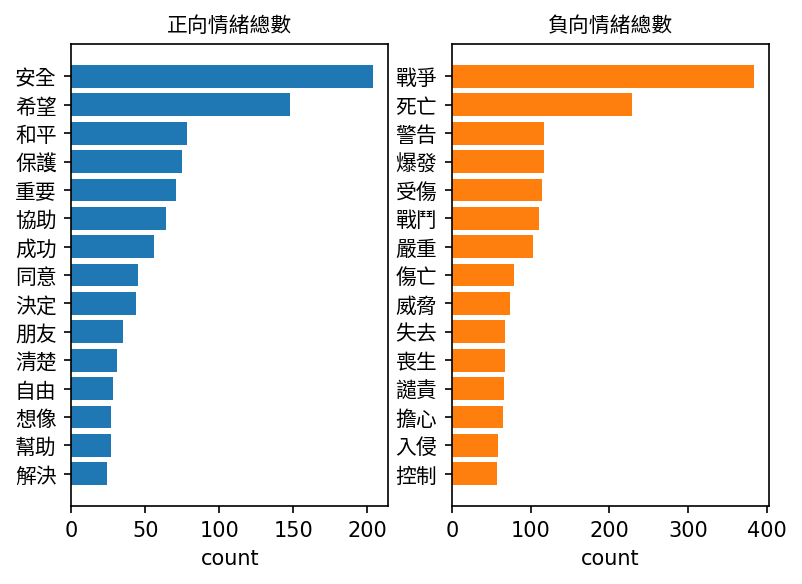

In [103]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

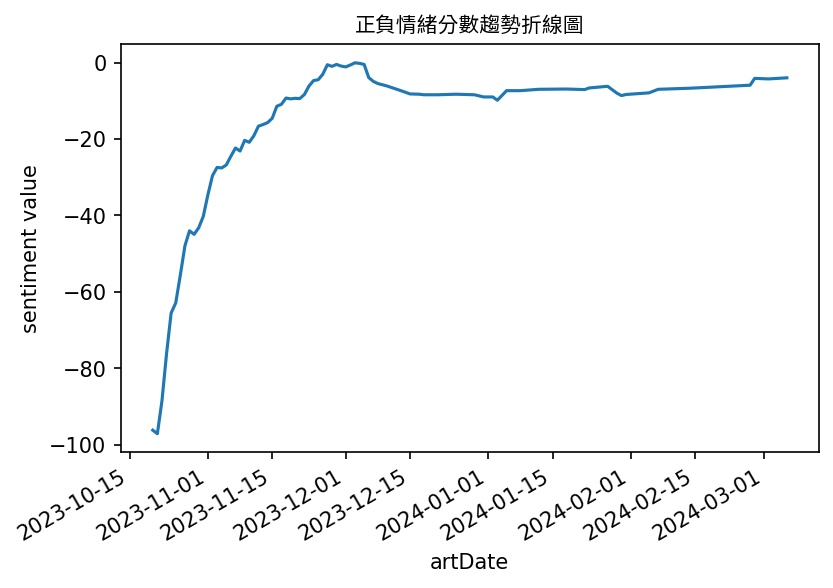

In [106]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.8 文字雲
如果文字雲中的字詞大小越大，代表出現頻率越高

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [107]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
0,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社,NaN,負向
1,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,記者,NaN,負向
2,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,報導,NaN,負向
3,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,軍隊,NaN,負向
4,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,今天,NaN,負向


In [108]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

,artTitle,artUrl,artDate,artContent,sentence,sentiment_class
0,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社記者報導,負向
1,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,以色列軍隊今天已對加薩走廊發動至少2次空襲,負向
2,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,在此之前,負向
3,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,哈瑪斯集團從加薩走廊向以色列發射大量火箭,負向
4,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,https://news.ebc.net.tw/news/article/385783,2023-10-07,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,以色列總理尼坦雅胡表示,負向


In [109]:
date = "2023-10-07"
end_date = "2024-03-09"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
0,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,法新社,NaN,負向
1,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,記者,NaN,負向
2,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,報導,NaN,負向
3,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,軍隊,NaN,負向
4,https://news.ebc.net.tw/news/article/385783,2023-10-07,以色列空襲回擊哈瑪斯！總理宣布戰爭狀態 喊話：敵人將付出代價｜東森新聞,法新社記者報導，以色列軍隊今天已對加薩走廊發動至少2次空襲。在此之前，哈瑪斯集團從加薩走廊向...,今天,NaN,負向
...,...,...,...,...,...,...,...
104943,https://news.ebc.net.tw/news/article/407989,2024-03-02,加薩搶糧混戰逾百死 拜登：美軍將空投物資｜東森新聞,加薩市昨天發生以色列軍人被控朝搶糧的巴勒斯坦人開槍造成逾百死事件，當地人道災難持續惡化再度引...,威脅,negative,負向
104944,https://news.ebc.net.tw/news/article/407989,2024-03-02,加薩搶糧混戰逾百死 拜登：美軍將空投物資｜東森新聞,加薩市昨天發生以色列軍人被控朝搶糧的巴勒斯坦人開槍造成逾百死事件，當地人道災難持續惡化再度引...,威脅,anx,負向
104945,https://news.ebc.net.tw/news/article/407989,2024-03-02,加薩搶糧混戰逾百死 拜登：美軍將空投物資｜東森新聞,加薩市昨天發生以色列軍人被控朝搶糧的巴勒斯坦人開槍造成逾百死事件，當地人道災難持續惡化再度引...,威脅,anger,負向
104946,https://news.ebc.net.tw/news/article/407989,2024-03-02,加薩搶糧混戰逾百死 拜登：美軍將空投物資｜東森新聞,加薩市昨天發生以色列軍人被控朝搶糧的巴勒斯坦人開槍造成逾百死事件，當地人道災難持續惡化再度引...,群眾,NaN,負向


In [110]:
date = "2023-10-07"
end_date = "2024-03-09"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "正向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
2994,瑪斯,276
3419,美國,207
541,人質,204
940,加薩,117
1751,希望,102
...,...,...
1993,戈倫,1
1995,成受,1
1997,成員國,1
1999,成效,1


(-0.5, 399.5, 199.5, -0.5)

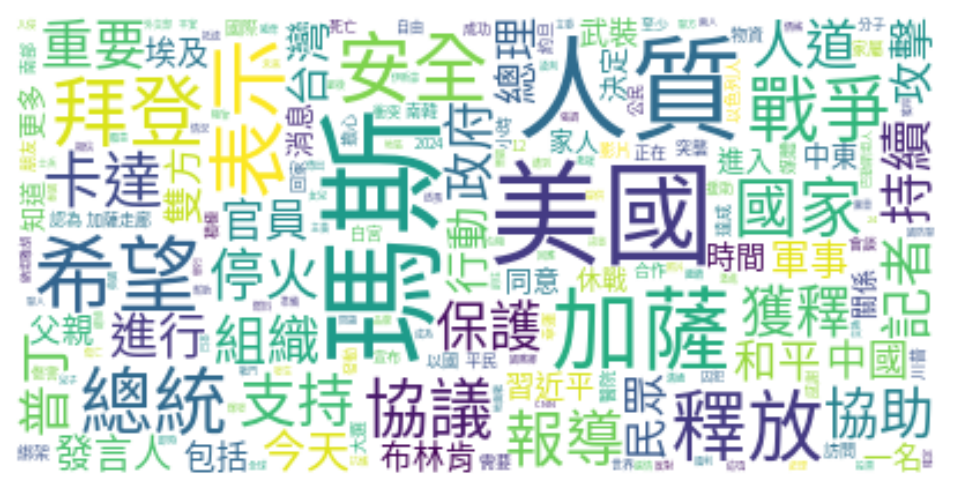

In [111]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

In [112]:
date = "2023-10-07"
end_date = "2024-03-09"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
8134,瑪斯,1757
2642,加薩,1308
5461,戰爭,1074
9202,美國,638
6207,攻擊,611
...,...,...
1553,人座,1
6817,未知數,1
6815,未盡,1
6814,未然,1


(-0.5, 399.5, 199.5, -0.5)

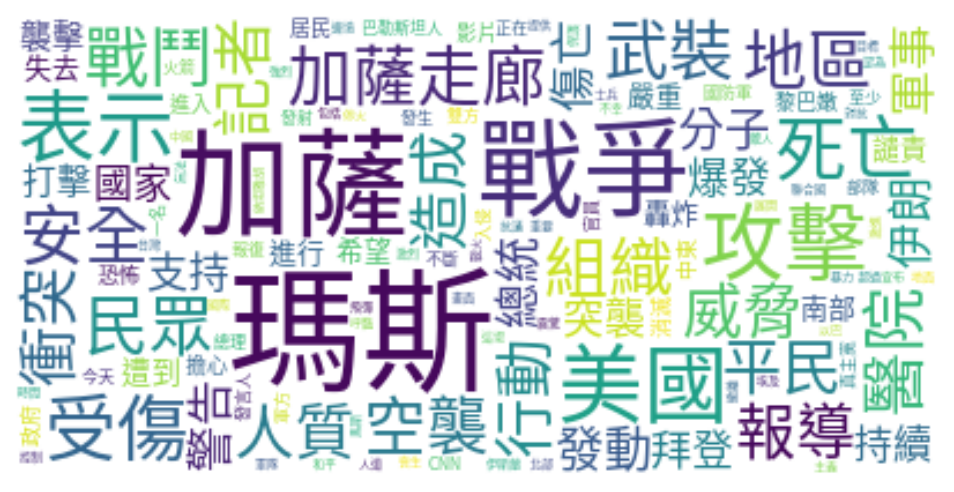

In [113]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

(-0.5, 399.5, 199.5, -0.5)

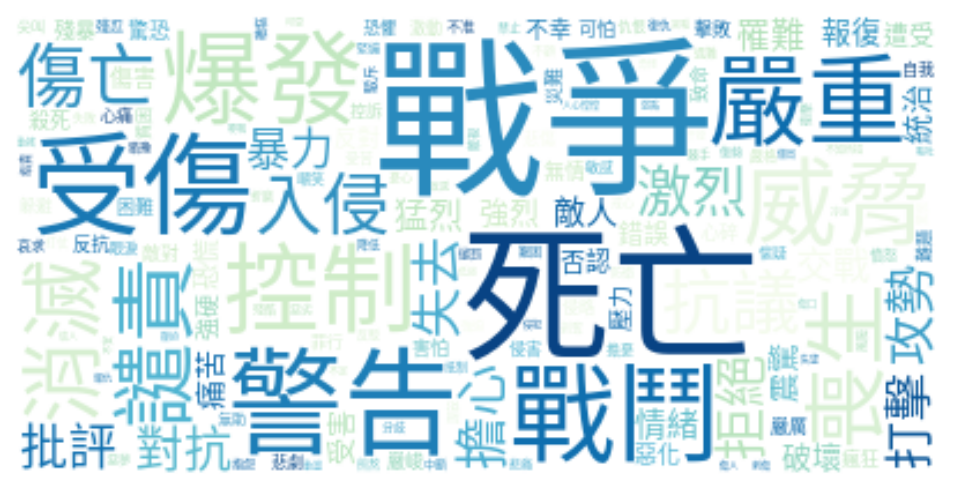

In [114]:
date = "2023-10-07"
end_date = "2024-03-09"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('人質')) & ( # 內文包含雞腿排
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

利用「缺點」去查看原文內容

In [115]:
date = "2023-10-07"
end_date = "2024-03-09"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('擔心')) & (
    sent_df['sentence'].str.contains('報復')) # 包含「缺點」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artTitle,artUrl,artDate,artContent,sentence,sentiment_class
4493,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,包括軍事陣地哈瑪斯領導人的住宅和銀行,負向
4494,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,加薩民眾都躲在室內,負向
4495,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,8日爆炸聲持續不斷,負向
4496,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,而瓦坦塔更是重災區,負向
4497,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,巴勒斯坦衛生官員說,負向
4498,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,以色列對加薩的報復性空襲,負向
4499,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,造成400人死亡,負向
4500,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,據了解,負向
4501,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,由於以色列對加薩斷電,負向
4502,以巴衝突／以色列回擊！加薩醫院塞爆 實習醫獨撐外科｜東森新聞,https://news.ebc.net.tw/news/article/386185,2023-10-10,巴勒斯坦激進組織哈瑪斯7日向以色列發動突襲，而以色列回擊狂轟加薩，以色列軍隊稱，已襲擊加薩1...,當地的供應商只能提供該地所需電力的20,負向
